In [110]:
import numpy as np
import pandas as pd
import geopandas as gpd

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
import pickle

from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt

# Load in Data & Stopwords

In [26]:
df = pd.read_csv('data/airbnb_words.csv')
df = df.dropna()
df.head()

,neighborhood_id,descriptions
0,1,Situated right in the heart of the Bronx where...
1,2,Quiet and family friendly. Here is what is ne...
2,3,"Our neighborhood, within NYC, is called Astori..."
3,4,Real Brooklyn experience! Residential neighbor...
4,5,Nearby Attractions: - Run/bike along Hudson Ri...


In [44]:
with open("stopwords.txt", "rb") as fp:   
   sw = pickle.load(fp)

In [134]:
nyc = gpd.read_file('data/geojson/combinedneighborhoods.geojson')
nyc = nyc[['Unique Identifier','geometry']]
nyc.columns=['neighborhood_id','geometry']
nyc.head()

,neighborhood_id,geometry
0,1,POLYGON ((-73.85663664103342 40.85811529295128...
1,2,POLYGON ((-74.17185166456856 40.56152092302123...
2,3,POLYGON ((-73.90202516499477 40.76741678384665...
3,4,POLYGON ((-74.00200394611576 40.59413237177825...
4,5,(POLYGON ((-74.00078295209646 40.6942865161671...


# Vectorize

In [45]:
vectorizer = TfidfVectorizer(stop_words=sw,min_df=0.2,max_df=0.9)

In [46]:
X = vectorizer.fit_transform(df['descriptions'].tolist())

/usr/local/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['bull', 'co', 'lefferts', 'op', 'prince'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


In [47]:
vectorizer.get_feature_names()

['10',
 '100',
 '10min',
 '11',
 '12',
 '13',
 '15',
 '15min',
 '18',
 '19th',
 '20',
 '21',
 '24',
 '24hr',
 '25',
 '30',
 '35',
 '40',
 '45',
 '50',
 '5min',
 'able',
 'abound',
 'absolutely',
 'abundance',
 'accessible',
 'action',
 'active',
 'activities',
 'activity',
 'actually',
 'addition',
 'additionally',
 'adjacent',
 'advantage',
 'affordable',
 'african',
 'ages',
 'aid',
 'air',
 'airport',
 'airports',
 'alike',
 'almost',
 'although',
 'amazing',
 'amenities',
 'america',
 'american',
 'americans',
 'among',
 'ample',
 'another',
 'anyone',
 'anything',
 'anywhere',
 'apartments',
 'apple',
 'approximately',
 'apt',
 'architecture',
 'array',
 'art',
 'artistic',
 'artists',
 'arts',
 'asian',
 'ask',
 'atlantic',
 'attraction',
 'authentic',
 'available',
 'avenues',
 'award',
 'awesome',
 'back',
 'backyard',
 'bagel',
 'bagels',
 'bakeries',
 'bakery',
 'bank',
 'banks',
 'bar',
 'barber',
 'barclays',
 'barrio',
 'bars',
 'base',
 'baseball',
 'based',
 'basketball'

In [49]:
print(X.shape)

(145, 1094)


# K-Means Clustering of Vectorized Features

In [138]:
n_clusters = 8

In [142]:
cols = []
for i in range(n_clusters):
    cols.append('pc' + str(i+1))
print(cols)

['pc1', 'pc2', 'pc3', 'pc4', 'pc5', 'pc6', 'pc7', 'pc8']


In [139]:
Kmean = KMeans(n_clusters=n_clusters)
Kmean.fit(X)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=8, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [140]:
Kmean.inertia_

86.03011674818211

In [141]:
df['kmean'] = Kmean.labels_
df.head()

,neighborhood_id,descriptions,kmean
0,1,Situated right in the heart of the Bronx where...,4
1,2,Quiet and family friendly. Here is what is ne...,0
2,3,"Our neighborhood, within NYC, is called Astori...",7
3,4,Real Brooklyn experience! Residential neighbor...,2
4,5,Nearby Attractions: - Run/bike along Hudson Ri...,2


# SVD (Dimensionality Reduction) of Vectorized Features

In [157]:
svd = TruncatedSVD(n_components=8)
principalComponents = svd.fit_transform(X)
principalDf = pd.DataFrame(data = principalComponents,columns=cols)
svd.explained_variance_ratio_

array([0.04090376, 0.07480943, 0.0323591 , 0.02754008, 0.02446408,
       0.02112276, 0.02049312, 0.01824112])

In [158]:
svd.explained_variance_ratio_.sum()

0.25993344354617065

In [159]:
svdDf = pd.DataFrame(data = svd.components_.T, columns =cols)
svdDf = pd.concat([pd.Series(vectorizer.get_feature_names()),svdDf],axis=1)
svdDf.head()

,0,pc1,pc2,pc3,pc4,pc5,pc6,pc7,pc8
0,10,0.141419,-0.097820,-0.105100,-0.072499,0.229664,0.051114,-0.014560,-0.072677
1,100,0.014776,0.006331,0.013845,-0.009962,0.022510,-0.005545,0.018883,-0.024504
2,10min,0.006527,-0.002727,0.003569,-0.014371,0.007938,-0.000038,0.005671,0.008707
3,11,0.014951,-0.005937,-0.027106,-0.003469,0.023690,-0.005693,0.017354,-0.031079
4,12,0.018784,-0.017066,0.008025,-0.002958,0.019868,0.005826,-0.000186,0.014143


In [160]:
svdDf.sort_values(by='pc1',ascending=False).head()

,0,pc1,pc2,pc3,pc4,pc5,pc6,pc7,pc8
87,bars,0.243811,0.414020,-0.043312,-0.055476,0.011451,-0.099857,0.025473,-0.086259
838,safe,0.196409,-0.170601,-0.113984,-0.041693,-0.291658,-0.217718,0.035813,0.227514
404,food,0.184508,-0.092238,-0.073221,-0.108838,-0.122877,0.022306,-0.137555,-0.148506
1002,train,0.182788,-0.108626,0.060763,-0.126761,-0.247754,0.066837,-0.009044,-0.034327
874,shops,0.179543,0.115015,0.017484,-0.032263,-0.047522,-0.071988,-0.093716,0.122814


In [161]:
svdDf.sort_values(by='pc2',ascending=False).head()

,0,pc1,pc2,pc3,pc4,pc5,pc6,pc7,pc8
87,bars,0.243811,0.414020,-0.043312,-0.055476,0.011451,-0.099857,0.025473,-0.086259
155,cafes,0.092464,0.162672,0.001680,-0.022485,-0.040789,0.000854,-0.092445,0.017882
208,coffee,0.118131,0.156628,0.026219,-0.003580,-0.005803,-0.032490,-0.050059,-0.024827
422,galleries,0.041918,0.135186,-0.036436,-0.036556,0.060064,0.014974,0.083334,-0.037240
828,river,0.081026,0.131969,-0.008104,-0.033665,0.078422,0.018121,0.227688,0.119804


In [162]:
svdDf.sort_values(by='pc3',ascending=False).head()

,0,pc1,pc2,pc3,pc4,pc5,pc6,pc7,pc8
1093,zoo,0.070017,-0.111561,0.428836,0.072316,0.032117,0.017425,-0.049171,-0.112967
125,botanical,0.072727,-0.073666,0.408354,0.036894,0.063375,0.032052,-0.122707,-0.050614
916,stadium,0.073072,-0.130469,0.316204,-0.005614,0.020259,0.096472,0.380424,0.002029
426,garden,0.074079,-0.034782,0.243458,-0.005416,0.071581,0.022456,-0.041449,-0.005911
653,museum,0.120780,0.108837,0.197044,0.053411,0.204719,-0.001783,0.038967,0.138384


In [165]:
principalDf = pd.concat([df[['neighborhood_id','kmean']],principalDf], axis = 1)
principalDf.head()

,neighborhood_id,kmean,pc1,pc2,pc3,pc4,pc5,pc6,pc7,pc8
0,1.0,4.0,0.536142,-0.331624,0.311554,0.019884,0.066799,0.006508,-0.105827,0.073956
1,2.0,0.0,0.260886,-0.158908,-0.065765,0.140822,0.058659,0.026510,0.005053,0.185169
2,3.0,7.0,0.790521,0.250964,-0.045252,-0.122134,-0.028887,-0.081969,0.053378,-0.084249
3,4.0,2.0,0.414324,-0.086896,-0.175479,0.081154,0.053823,0.117782,-0.015782,0.167309
4,5.0,2.0,0.345209,0.192756,-0.078315,0.103257,0.090511,-0.012233,0.065294,-0.042835


In [166]:
nyc = nyc.merge(principalDf,on='neighborhood_id')
nyc.head()

,neighborhood_id,geometry,kmean,pc1,pc2,pc3,pc4,pc5,pc6,pc7,pc8
0,1,POLYGON ((-73.85663664103342 40.85811529295128...,4.0,0.536142,-0.331624,0.311554,0.019884,0.066799,0.006508,-0.105827,0.073956
1,2,POLYGON ((-74.17185166456856 40.56152092302123...,0.0,0.260886,-0.158908,-0.065765,0.140822,0.058659,0.026510,0.005053,0.185169
2,3,POLYGON ((-73.90202516499477 40.76741678384665...,7.0,0.790521,0.250964,-0.045252,-0.122134,-0.028887,-0.081969,0.053378,-0.084249
3,4,POLYGON ((-74.00200394611576 40.59413237177825...,2.0,0.414324,-0.086896,-0.175479,0.081154,0.053823,0.117782,-0.015782,0.167309
4,5,(POLYGON ((-74.00078295209646 40.6942865161671...,2.0,0.345209,0.192756,-0.078315,0.103257,0.090511,-0.012233,0.065294,-0.042835


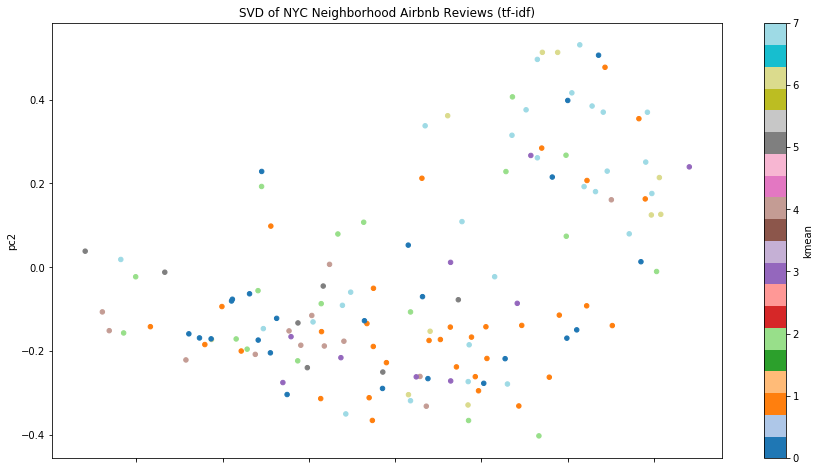

In [188]:
principalDf.plot.scatter(x='pc1',y='pc2',c='kmean',colormap = 'tab20',figsize=(15,8))
plt.title('SVD of NYC Neighborhood Airbnb Reviews (tf-idf)')
plt.savefig('images/tfidf-svd.png')

/usr/local/lib/python3.7/site-packages/geopandas/plotting.py:459: FutureWarning: 'colormap' is deprecated, please use 'cmap' instead (for consistency with matplotlib)
  FutureWarning,


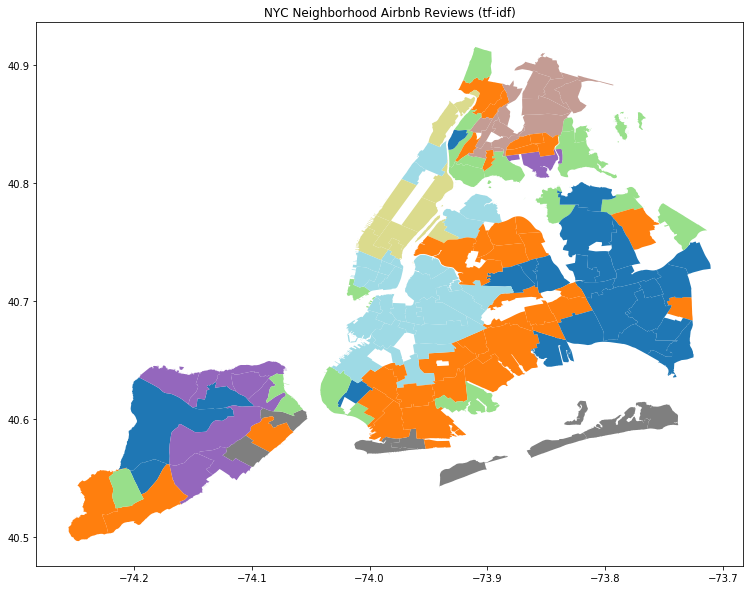

In [189]:
nyc2.plot(column='kmean',colormap='tab20',figsize=(20,10))
plt.title('NYC Neighborhood Airbnb Reviews (tf-idf)')
plt.savefig('images/tfidf-map.png')